<a href="https://colab.research.google.com/github/pekgnee/simple-bot-for-tourism/blob/master/Simple_Bot_for_tourism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Build a basic bot

### Installation
First we'll have to install Rasa Core on the server running this notebook. In this first step, your bot won't understand natural language yet. This happens in Step 2. **Run the cell below, this will take a couple of minutes to complete so this is a good time to scroll through the rest of the notebook.**

**Make sure to install the correct version. If you want to experiment with the latest master, use**: 

`!pip install -U git+https://github.com/rasahq/rasa_core.git`

In [0]:
!pip -qq install rasa-core==0.11.8

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

### Writing Stories

A good place to start is by writing a few stories. These are example conversations that Rasa Core will learn from. 

The format works like this:

A story starts with `##` and you can give it a name. 
lines that start with `*` are messages sent by the user. Although you don't write the *actual* message, but rather the intent (and the entities) that represent what the user *means*. If you don't know about intents and entities, don't worry! We will talk about them more later. 
Lines that start with `-` are *actions* taken by your bot. In this case all of our actions are just messages sent back to the user, like `utter_greet`, but in general an action can do anything, including calling an API and interacting with the outside world. 

In [56]:
stories_md = """
## search attraction
* search_attraction{"attraction": "Sentosa Merlion"}
  - action_get_attraction_entity
  - slot{"attraction": "Sentosa Merlion"}
  - utter_search_attraction
  - action_search_attraction
  - slot{"search_result": "Ticket prices are $X(adult) & $Y*(child)"}
  - utter_search_result
* check_info{"info_field": "nearestMrtStation"}
  - action_get_info_field_entity
  - slot{"info_field": "nearestMRTStation"}
  - utter_check_info
  - action_check_info
  - slot{"info_result": "Holland Village"}
  - utter_info_result
* no_other_request
  - utter_no_other_request
 

## search_hotel
* search_hotel{"hotel": "Hotel Royal"}
  - action_get_hotel_entity
  - slot{"hotel": "Hotel Royal"}
  - utter_search_hotel
  - action_search_hotel
  - slot{"search_result": "5-star hotel located in Orchard area"}
  - utter_search_result
* check_info
  - action_get_info_field_entity
  - slot{"info_field": "amenaties"}
  - utter_check_info
  - action_check_info
  - slot{"info_result": "swimming pool"}
  - utter_info_result
* no_other_request
  - utter_no_other_request

"""

# Other possible stories based on Tourism Info Hub - Content API for Consumer
# - Search Bars and Clubs
# - Search Event
# - Search Food and Beverages
# - Search Malls and Shops
# - Search Tour
# - Search Venue
# - Search Walking Trail


%store stories_md > stories.md

Writing 'stories_md' (str) to file 'stories.md'.


### Defining a Domain

The domain specifies the universe that your bot lives in. You should list all of the intents and actions that show up in your stories. 
This is also the place to write templates, which contain the messages your bot can send back

In [58]:
domain_yml = """
intents:
  - search_attraction
  - search_hotel
  - check_info
  - no_other_request

slots:
  attraction:
    type: text
  hotel:
    type: text    
  search_result:
    type: text
  info_field:
    type: text
  info_result:
    type: text

actions:
- action_get_attraction_entity
- utter_search_attraction
- action_search_attraction
- utter_search_result
- action_get_info_field_entity
- utter_check_info
- action_check_info
- utter_info_result
- utter_no_other_request
- action_get_hotel_entity
- utter_search_hotel
- action_search_hotel

templates:
  utter_search_attraction:
  - text: "Searching attraction {attraction}"

  utter_search_hotel:
  - text: "Searching hotel {hotel}"

  utter_search_result:
  - text: "Found result {search_result}"

  utter_check_info:
  - text: "Checking for {info_field}"

  utter_info_result:
  - text: "Found info {info_result}"

  utter_no_other_request:
  - text: "Have a nice day"
  - text: "Thank you"
  - text: "Bye"
  
"""

%store domain_yml > domain.yml

Writing 'domain_yml' (str) to file 'domain.yml'.


### Training your Dialogue Model

Now comes the fun part! We're going to show Rasa Core the stories we wrote above, and train a model on these examples. 
In this case, the model is a neural network implemented in Keras which learns to predict which action to take next. 

In [59]:
from rasa_core.policies.keras_policy import KerasPolicy
from rasa_core.agent import Agent

agent = Agent('domain.yml', policies=[KerasPolicy()])
training_data = agent.load_data('stories.md')

agent.train(
        training_data,
        validation_split=0.0,
        epochs=400
)

agent.persist('models/dialogue')

Processed Story Blocks: 100%|██████████| 2/2 [00:00<00:00, 128.05it/s, # trackers=6]
INFO:rasa_core.policies.keras_policy:Fitting model with 85 total samples and a validation split of 0.0


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 5, 24)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                7296      
_________________________________________________________________
dense (Dense)                (None, 15)                495       
_________________________________________________________________
activation (Activation)      (None, 15)                0         
Total params: 7,791
Trainable params: 7,791
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
85/85 [==============================] - 1s 8ms/sample - loss: 2.7347 - acc: 0.0941
Epoch 2/400
85/85 [==============================] - 0s 736us/sample - loss: 2.7144 - acc: 0.1294
Epoch 3/400
85/85 [==============================] - 0s 801us/sample - loss: 2

INFO:rasa_core.policies.keras_policy:Done fitting keras policy model
INFO:rasa_core.agent:Model directory models/dialogue exists and contains old model files. All files will be overwritten.
INFO:rasa_core.agent:Persisted model to '/content/models/dialogue'


### Defining Custom Actions
Define custom actions to retrieve data from Tourism Information & Services Hub (TIH) API  
https://tih-dev.stb.gov.sg/content-api/apis

[Register as a developer](https://tih.stb.gov.sg/content/tih/en/profile/register.html) to receive apikey required to run custom action server  
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++  
**MANDATORY**  
***Pls replace apikey in actions.py with a valid one and upload actions.py to Colab /content root folder,  
otherwise action server will not work !!***  
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++  
As per https://forum.rasa.com/t/run-actions-without-action-server/6411 custom actions can only be run from a separate action server.  
Therefore we run it as nohup python3 from bash and ps before/after in case you need to kill the PID and re-start action server


In [61]:
!ps
!nohup python3 -m rasa_core_sdk.endpoint --actions actions > my.log 2>&1 &
!ps

    PID TTY          TIME CMD
      1 ?        00:00:00 run.sh
     10 ?        00:00:02 node
     26 ?        00:00:09 node
     36 ?        00:00:18 jupyter-noteboo
    128 ?        00:00:00 tail
    141 ?        00:02:52 python3
    159 ?        00:00:00 python3
   2337 ?        00:00:00 ps
    PID TTY          TIME CMD
      1 ?        00:00:00 run.sh
     10 ?        00:00:02 node
     26 ?        00:00:09 node
     36 ?        00:00:18 jupyter-noteboo
    128 ?        00:00:00 tail
    141 ?        00:02:52 python3
    159 ?        00:00:00 python3
   2339 ?        00:00:00 python3
   2344 ?        00:00:00 ps


### Debugging step -- no need to run
Code below is only for debugging purpose  
Compare the two ps printout above to get the new python PID started by nohup python3  
And kill the PID if you need to re-start action server

In [60]:
# !kill 981
# !ps

    PID TTY          TIME CMD
      1 ?        00:00:00 run.sh
     10 ?        00:00:02 node
     26 ?        00:00:09 node
     36 ?        00:00:18 jupyter-noteboo
    128 ?        00:00:00 tail
    141 ?        00:02:51 python3
    159 ?        00:00:00 python3
   2336 ?        00:00:00 ps


### Check that action server is up and running
The logs should show "Action endpoint is up and running. on ('0.0.0.0', 5055)"  where DEFAULT_SERVER_PORT = 5055  
Or check logs again later to see if to see action server received request to run actions

In [62]:
!more my.log

INFO:__main__:Starting action endpoint server...
INFO:rasa_core_sdk.executor:Registered function for 'action_get_attraction_entit
y'.
INFO:rasa_core_sdk.executor:Registered function for 'action_search_attraction'.
INFO:rasa_core_sdk.executor:Registered function for 'action_get_info_field_entit
y'.
INFO:rasa_core_sdk.executor:Registered function for 'action_check_info'.
INFO:rasa_core_sdk.executor:Registered function for 'action_get_hotel_entity'.
INFO:rasa_core_sdk.executor:Registered function for 'action_search_hotel'.
INFO:__main__:Action endpoint is up and running. on ('0.0.0.0', 5055)


### Starting up the bot
Lets start up the bot and call action server through default http://localhost:5055/webhook


In [0]:
from rasa_core.agent import Agent
from rasa_core.utils import EndpointConfig
core_endpoint_config = EndpointConfig(url='http://localhost:5055/webhook')
agent = Agent.load('models/dialogue', action_endpoint = core_endpoint_config)

### Talking to the bot (no NLU)

In this step, we just trained the dialogue model - so basically the conversational flow. So the bot will only understand **structured** input and **no** natural language yet. Go try it out with typing  "/" + one of the intents from your domain before, e.g.:

/search_hotel

/search_attraction

/check_info

/no_other_request

In [64]:
print("Your bot is ready to talk! Type your messages here or send 'stop'")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_text(a)
    for response in responses:
        print(response)
        print(response["text"])

Your bot is ready to talk! Type your messages here or send 'stop'
/search_hotel
{'recipient_id': 'default', 'text': 'Searching hotel The Fullerton Hotel Singapore'}
Searching hotel The Fullerton Hotel Singapore
{'recipient_id': 'default', 'text': 'Found result {\'address\': {\'block\': \'\', \'buildingName\': \'\', \'floorNumber\': \'\', \'postalCode\': \'049326\', \'streetName\': \'1 Fullerton Square\', \'unitNumber\': \'\'}, \'body\': \'\', \'categoryDescription\': \'Accommodation\', \'companyDisplayName\': \'stb\', \'dataset\': \'accommodation\', \'defaultLanguage\': \'EN\', \'description\': \'The Fullerton Hotel Singapore is a stunning 400-room heritage hotel in Singapore.\', \'documents\': [], \'images\': [], \'leadInRoomRates\': \'S$301 - S$400\', \'location\': {\'latitude\': 1.2863532, \'longitude\': 103.8530671}, \'metadata\': {\'createdBy\': \'chris_sim@stb.gov.sg\', \'createdDate\': \'2018-12-31T10:36:13Z\', \'updatedBy\': \'chris_sim@stb.gov.sg\', \'updatedDate\': \'2018-12-

# Part 2: Add natural language understanding

So far, our bot doesn't understand regular sentences with natural language yet.
To do that, we're going to build a language understanding model with Rasa NLU. 

### Installing NLU
We have to install a couple of more things in this notebook here. **Run the cell below** - in the meantime, you can check out the rest of the code.


In [40]:
!apt-get -qq install -y graphviz libgraphviz-dev pkg-config && pip install pygraphviz;
!pip install rasa_nlu[spacy];
!python -m spacy download en;

Selecting previously unselected package libgtk2.0-common.
(Reading database ... 131294 files and directories currently installed.)
Preparing to unpack .../0-libgtk2.0-common_2.24.32-1ubuntu1_all.deb ...
Unpacking libgtk2.0-common (2.24.32-1ubuntu1) ...
Selecting previously unselected package libgtk2.0-0:amd64.
Preparing to unpack .../1-libgtk2.0-0_2.24.32-1ubuntu1_amd64.deb ...
Unpacking libgtk2.0-0:amd64 (2.24.32-1ubuntu1) ...
Selecting previously unselected package libgail18:amd64.
Preparing to unpack .../2-libgail18_2.24.32-1ubuntu1_amd64.deb ...
Unpacking libgail18:amd64 (2.24.32-1ubuntu1) ...
Selecting previously unselected package libgail-common:amd64.
Preparing to unpack .../3-libgail-common_2.24.32-1ubuntu1_amd64.deb ...
Unpacking libgail-common:amd64 (2.24.32-1ubuntu1) ...
Selecting previously unselected package libxdot4.
Preparing to unpack .../4-libxdot4_2.40.1-2_amd64.deb ...
Unpacking libxdot4 (2.40.1-2) ...
Selecting previously unselected package libgvc6-plugins-gtk.
Prep

### Language Understanding


Lets create some training data here, grouping user messages by their `intent`s. The intent describes what the messages *mean*. 

In [65]:
nlu_md = """
## intent:search_attraction
- I'm interested to visit [Sentosa Merlion](attraction)
- I would like to visit [Singapore Zoo](attraction)
- I want to visit the [Singapore Flyer](attraction)
- I'm planning to visit [Singapore Art Museum](attraction)
- I'm thinking to visit [Singapore Botanic Gardens](attraction)
- I might want to visit [Singapore Philatelic Museum](attraction)
- I'm looking for information about [Science Centre Singapore](attraction)
- Do you have any information about [National Gallery Singapore](attraction)
- I'd like to have some information about [National Museum of Singapore](attraction)
- Can you help me with information about [The Southern Ridges](attraction)
- I need some information about [Henderson Waves](attraction)
- I'm looking for information about [The Substation](attraction)
- I read about [Gardens by the Bay](attraction) and I would like to visit
- I heard about[Reflections at Bukit Chandu](attraction) and I'm planning to visit it
- I saw a picture of [Marina Bay Sands](attraction) and I would like to see it
- I saw [River Safari](attraction) in a tv program and I'm interested to visit it
- I come across [Sun Yat Sen Nanyang Memorial Hall](attraction) in a magazine and I would like to know more about it
- My friend told me about [MacRitchie Reservoir Park](attraction) and I want to go there
- My friend visited Singapore some time ago and she had a good experience at [ArtScience Museum](attraction)
- Our friends tell us we should visit [Rail Corridor](attraction) when we're in Singapore
- I was told that I should visit [Resorts World Sentosa](attraction) while in Singapore


## intent:search_hotel
- I'm looking for information about [The Fullerton Hotel Singapore](hotel)
- I would like to get some information about [The Quay Hotel](hotel)
- Do you have information about [Hotel Royal](hotel)
- I'm searching for accommodation and I wonder if you have information about [Hotel Michael](hotel)
- I'll be in Singapore for 2 nights and I'm looking at staying at [Hotel Jen Tanglin Singapore](hotel)
- I considering to stay at [Hotel Indigo Singapore Katong](hotel) and I need some information
- I want to know more about [Hotel Yan](hotel) as I might want to stay there
- I looking for accommodation and [Hotel Grand Central](hotel) is one of the choices. Do you have any information for it?
- I'm looking for a hotel to stay - Do you know about [Hotel Boss](hotel)
- I'm wondering if you can help me with information about [Hotel Clover 7](hotel)
- Can you help to check information about [Festive Hotel](hotel)
- I need a place to stay in Singapore and I'm considering [Equarius Hotel](hotel). Can you help me find some information for that?
- I'm trying to find out more about [Arcadia Hotel](hotel) because I want to stay there
- I'm searching for information on a hotel called [Copthorne King's Hotel Singapore](hotel)
- I'd like to find out more about [One Farrer Hotel](hotel) - we're thinking to stay there
- I need some information about a hotel ["Village Hotel Katongl Singapore](hotel)
- I want to know more about [Village Hotel Changi](hotel) before I make a reservation to stay there


## intent:check_info
- What is the [nearest mrt](info_field) to the place
- Do you know what is the [address](info_field)
- I would like to know the [business hour](info_field)
- I want to find out the [admission info](info_field)
- I'm looking for the [contact](info_field)
- Can you help me find the [official website](info_field)
- Will you be able to check what are the [amenities](info_field)
- I want to find out which is the [nearest underground](info_field)
- Is it possible to check the [train station](info_field)
- Do you have information about the [nearby mrt](info_field)
- I'm actually searching for the [nearest mrt](info_field)
- I'm trying to find the [ticket price](info_field)
- How can I get there, is there a [mrt stop nearby](info_field)
- From which [nearby public transport](info_field) can I get there
- I would like to get there by MRT - do you know at which [mrt](info_field) should I stop
- How can I get there by [train](info_field)



## intent:no_other_request
- I don't have any more questions
- No more questions from me
- Thank you, that's all I need
- Ok I think I have everything I need
- That's it, I'm good to go
- That was very great help indeed
- Yes, that's all that I need
- You have answered all my questions
- That's all I need
- Thank you so much for the help
- Thanks for the help then
- Ok then, I'll be going
- okie dokie
- Bye then
- Cheers
- It was great talking to you

## synonym:nearestMrtStation
- mrt
- mrt station
- mrt stop
- train
- train station
- public transport
- underground
- metro
- metro station
- nearest mrt
- nearest mrt station
- nearest mrt stop
- nearest train station
- nearest public transport
- nearest underground
- nearest metro
- nearest metro station
- nearby mrt
- nearby mrt station
- nearby mrt stop
- nearby train station
- nearby public transport
- nearby underground
- nearby metro
- nearby metro station
- mrt nearby
- mrt station nearby
- mrt stop nearby
- train station nearby
- public transport nearby
- underground nearby
- metro nearby
- metro station nearby

## synonym:businessHour
- business hour

## synonym:admissionInfo
- admission info
- ticket price
- ticket prices
- cost

## synonym:officialWebsite
- official website
- company website

"""

%store nlu_md > nlu.md

Writing 'nlu_md' (str) to file 'nlu.md'.


### Train the Rasa NLU Model

We're going to train a model to recognise these intents, so that when we send a message like "hello" to our bot, it will recognise this as a "greet" intent.

In [66]:
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer

training_data = load_data('nlu.md')
pipeline = [{"name": "nlp_spacy"},
            {"name": "tokenizer_spacy"},
            {"name": "intent_entity_featurizer_regex"},
            {"name": "intent_featurizer_spacy"},
            {"name": "ner_crf"},
            {"name": "ner_synonyms"},
            {"name": "intent_classifier_sklearn"}]
trainer = Trainer(RasaNLUModelConfig({"pipeline": pipeline}))
interpreter = trainer.train(training_data)
model_directory = trainer.persist('./projects/default/')

INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 70 (4 distinct intents)
	- Found intents: 'search_hotel', 'search_attraction', 'no_other_request', 'check_info'
	- entity examples: 54 (3 distinct entities)
	- found entities: 'info_field', 'hotel', 'attraction'

INFO:rasa_nlu.utils.spacy_utils:Trying to load spacy model with name 'en'
INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.model:Starting to train component nlp_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component tokenizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_entity_featurizer_regex
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_featurizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.2s finished
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Successfully saved model into '/content/projects/default/default/model_20190405-150423'


### Starting up the bot (with NLU)

Now that we've trained the dialogue **and** language understanding models and saved them, we can start up an `Agent` which will handle conversations for us. 

In [67]:
from rasa_core.utils import EndpointConfig
core_endpoint_config = EndpointConfig(url='http://localhost:5055/webhook')

from rasa_core.agent import Agent
agent = Agent.load('models/dialogue', interpreter=model_directory, action_endpoint = core_endpoint_config)

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.


### Talking to the Bot (with NLU)

We can start talking to the bot in natural language.

In [71]:
print("Your bot is ready to talk! Type your messages here or send 'stop'")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_text(a)
    for response in responses:
        print(response)


Your bot is ready to talk! Type your messages here or send 'stop'
I read about Gardens by the Bay and I would like to visit
{'recipient_id': 'default', 'text': 'Searching attraction gardens by the bay'}
{'recipient_id': 'default', 'text': 'Found result {\'address\': {\'block\': \'18\', \'buildingName\': \'\', \'floorNumber\': \'\', \'postalCode\': \'018953\', \'streetName\': \'Marina Gardens Drive\', \'unitNumber\': \'\'}, \'body\': \'Gardens by the Bay is an award winning horticultural destination and offers visitors a breath-taking views of the Marina Bay skyline. It comprises of three waterfront gardens and its iconic Supertrees will sparkle the Bay with its colourful solar-powered lights. The Bay offers the perfect setting for visitors to capture memorable moments.\', \'categoryDescription\': \'Attractions\', \'companyDisplayName\': \'stb\', \'dataset\': \'attractions\', \'defaultLanguage\': \'EN\', \'description\': \'This stunning man-made garden includes 18 Supertrees with over 1

### Pro Tip: Visualising the Training Data

You can visualise the stories to get a sense of how the conversations go. This is usually a good way to see if there are any stories which don't make sense


In [72]:
from rasa_core.agent import Agent
from IPython.display import IFrame

agent = Agent.load('models/dialogue')
agent.visualize("stories.md", "story_graph.jpg", max_history=2)

# IFrame(src="./story_graph.html", width=1000, height=800)

Processed Story Blocks: 100%|██████████| 2/2 [00:00<00:00, 159.12it/s, # trackers=1]


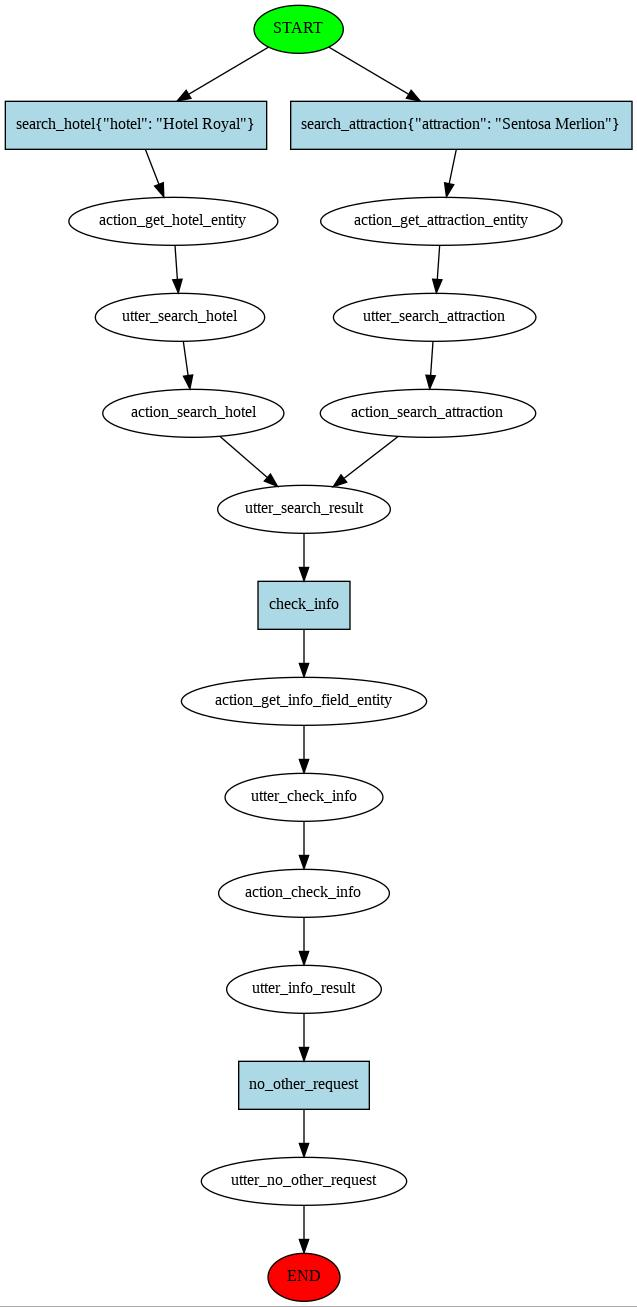

In [73]:
from IPython.display import Image

Image('./story_graph.jpg')

In [74]:
ls 

actions.py  models/  nlu.md     __pycache__/  stories.md
domain.yml  my.log   projects/  sample_data/  story_graph.jpg


# Part 3: Next steps

Great job! You've built your first bot that uses Machine Learning to manage dialogues. As a next step, we'd suggest you start building your own bot. Here are a few useful links:



*   Install the Rasa Stack on your machine [here](https://core.rasa.ai/installation.html)
*   Learn how to bootstrap training data with the [interactive learning tutorial](https://core.rasa.ai/tutorial_interactive_learning.html)
*   Connect to the community in our [Gitter Chat](https://gitter.im/RasaHQ/rasa_core)



---




*Any feedback for this tutorial?* Please shoot us an email at hi@rasa.com